<a href="https://colab.research.google.com/github/liusenlin2002-cmyk/time_series_projects/blob/main/challenge_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # 方法A：直接挂载（最简单）
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cross-Sectional Return Prediction — Data Challenge

**Objective**  
We study a cross-sectional return prediction problem using historical price-based features.
The goal is to construct a robust ranking signal for portfolio formation.

**Key Principles**
- Strictly no look-ahead bias
- Temporal models used only as feature extractors
- Emphasis on robustness and stability over peak performance


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt

np.random.seed(42)


## Data & Information Set

All features at time t are constructed using information available up to t.
The target is the forward return over the next period.


In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'AMZN']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')
data.head()


/tmp/ipython-input-2477596165.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2023-01-01')
[*********************100%***********************]  5 of 5 completed


Price           Close                                                \
Ticker           AAPL       AMZN       GOOG        META        MSFT   
Date                                                                  
2020-01-02  72.468269  94.900497  67.859535  208.324768  152.505692   
2020-01-03  71.763733  93.748497  67.526535  207.222488  150.606705   
2020-01-06  72.335556  95.143997  69.191544  211.125214  150.995987   
2020-01-07  71.995354  95.343002  69.148384  211.582031  149.619278   
2020-01-08  73.153488  94.598503  69.693298  213.727051  152.002472   

Price            High                                                ...  \
Ticker           AAPL       AMZN       GOOG        META        MSFT  ...   
Date                                                                 ...   
2020-01-02  72.528589  94.900497  67.897747  208.334693  152.610135  ...   
2020-01-03  72.523762  94.309998  68.114131  208.940483  151.869516  ...   
2020-01-06  72.374162  95.184502  69.305186  211.303958  151.062458  ...   
2020-01-07  72.600960  95.694504  69.627290  213.091491  151.603691  ...   
2020-01-08  73.455087  95.550003  70.053595  214.739979  152.676610  ...   

Price            Open                                                \
Ticker           AAPL       AMZN       GOOG        META        MSFT   
Date                                                                  
2020-01-02  71.476607  93.750000  66.578146  205.315788  150.758649   
2020-01-03  71.696175  93.224998  66.891300  205.772625  150.321872   
2020-01-06  70.885472  93.000000  66.997497  205.266132  149.144502   
2020-01-07  72.345204  95.224998  69.376675  211.343706  151.271381   
2020-01-08  71.698574  94.902000  69.085847  211.522449  150.901070   

Price          Volume                                          
Ticker           AAPL      AMZN      GOOG      META      MSFT  
Date                                                           
2020-01-02  135480400  80580000  28132000  12077100  22622100  
2020-01-03  146322800  75288000  23728000  11188400  21116200  
2020-01-06  118387200  81236000  34646000  17058900  20813700  
2020-01-07  108872000  80898000  30054000  14912400  21634100  
2020-01-08  132079200  70160000  30560000  13475000  27746500  

[5 rows x 25 columns]

In [ ]:
data.columns

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'AMZN'),
            ( 'Close', 'GOOG'),
            ( 'Close', 'META'),
            ( 'Close', 'MSFT'),
            (  'High', 'AAPL'),
            (  'High', 'AMZN'),
            (  'High', 'GOOG'),
            (  'High', 'META'),
            (  'High', 'MSFT'),
            (   'Low', 'AAPL'),
            (   'Low', 'AMZN'),
            (   'Low', 'GOOG'),
            (   'Low', 'META'),
            (   'Low', 'MSFT'),
            (  'Open', 'AAPL'),
            (  'Open', 'AMZN'),
            (  'Open', 'GOOG'),
            (  'Open', 'META'),
            (  'Open', 'MSFT'),
            ('Volume', 'AAPL'),
            ('Volume', 'AMZN'),
            ('Volume', 'GOOG'),
            ('Volume', 'META'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])

2️⃣构造成「panel data」格式

In [ ]:
df = data.stack().reset_index()
df

/tmp/ipython-input-3143301166.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = data.stack().reset_index()


Price,Date,Ticker,Close,High,Low,Open,Volume
0,2020-01-02,AAPL,72.468269,72.528589,71.223267,71.476607,135480400
1,2020-01-02,AMZN,94.900497,94.900497,93.207497,93.750000,80580000
2,2020-01-02,GOOG,67.859535,67.897747,66.578146,66.578146,28132000
3,2020-01-02,META,208.324768,208.334693,204.839122,205.315788,12077100
4,2020-01-02,MSFT,152.505692,152.610135,150.331386,150.758649,22622100
...,...,...,...,...,...,...,...
3775,2022-12-30,AAPL,127.998962,128.018669,125.536125,126.501564,77034200
3776,2022-12-30,AMZN,84.000000,84.050003,82.470001,83.120003,62401200
3777,2022-12-30,GOOG,88.069466,88.168720,86.382116,86.714622,19190300
3778,2022-12-30,META,119.505211,119.584658,116.923248,117.340341,19583800


In [ ]:
df = df.sort_values(['Ticker','Date'])

df['return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df = df.dropna()
df.head(5)

Price,Date,Ticker,Close,High,Low,Open,Volume,return
0,2020-01-02,AAPL,72.468269,72.528589,71.223267,71.476607,135480400,-0.009722
5,2020-01-03,AAPL,71.763733,72.523762,71.539345,71.696175,146322800,0.007968
10,2020-01-06,AAPL,72.335556,72.374162,70.634539,70.885472,118387200,-0.004703
15,2020-01-07,AAPL,71.995354,72.600960,71.775789,72.345204,108872000,0.016086
20,2020-01-08,AAPL,73.153488,73.455087,71.698574,71.698574,132079200,0.021241


In [ ]:
# R_(t)->R_(t+1)
df['return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df = df.dropna()

df['mom_20'] = df.groupby('Ticker')['return'].rolling(20).mean().reset_index(0, drop=True)
df['vol_20'] = df.groupby('Ticker')['return'].rolling(20).std().reset_index(0, drop=True)

#cross-sec zscore
def cs_zscore(x):
    return (x - x.mean()) / x.std()
df.head(30)


/tmp/ipython-input-3842968994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mom_20'] = df.groupby('Ticker')['return'].rolling(20).mean().reset_index(0, drop=True)
/tmp/ipython-input-3842968994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vol_20'] = df.groupby('Ticker')['return'].rolling(20).std().reset_index(0, drop=True)


Price,Date,Ticker,Close,High,Low,Open,Volume,return,mom_20,vol_20
0,2020-01-02,AAPL,72.468269,72.528589,71.223267,71.476607,135480400,-0.009722,NaN,NaN
5,2020-01-03,AAPL,71.763733,72.523762,71.539345,71.696175,146322800,0.007968,NaN,NaN
10,2020-01-06,AAPL,72.335556,72.374162,70.634539,70.885472,118387200,-0.004703,NaN,NaN
15,2020-01-07,AAPL,71.995354,72.600960,71.775789,72.345204,108872000,0.016086,NaN,NaN
20,2020-01-08,AAPL,73.153488,73.455087,71.698574,71.698574,132079200,0.021241,NaN,NaN
25,2020-01-09,AAPL,74.707321,74.900342,73.879735,74.130660,170108400,0.002261,NaN,NaN
30,2020-01-10,AAPL,74.876221,75.440821,74.374363,74.941371,140644800,0.021365,NaN,NaN
35,2020-01-13,AAPL,76.475914,76.502459,75.074081,75.192313,121532000,-0.013503,NaN,NaN
40,2020-01-14,AAPL,75.443237,76.623097,75.320190,76.413185,161954400,-0.004286,NaN,NaN
45,2020-01-15,AAPL,75.119919,76.123642,74.688027,75.242974,121923600,0.012526,NaN,NaN


描述性统计

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['return'], bins=50, kde=True)
plt.title('Return Distribution')
plt.show()


In [ ]:
corr = df[features + ['return']].corr()['return'].sort_values(ascending=False)
print(corr)

plt.figure(figsize=(10,4))
sns.barplot(x=corr.index[:-1], y=corr.values[:-1])
plt.xticks(rotation=45)
plt.title('Feature Correlation with Return')
plt.show()


In [ ]:
# 2️⃣ 高阶指标 + 缺失值
desc = df['return'].agg(['count','mean','std','min','median','max','skew','kurt'])
missing = df['return'].isnull().sum()
print(desc)
print('Missing values:', missing)

#分股票
df.groupby('Ticker')['return'].agg(['count','mean','std','min','median','max','skew','kurt'])

#按日期做截面统计（可选，用于时间序列趋势）
df.groupby('date')['return'].agg(['mean','std','skew','kurt'])



单股票收益分布（时间序列视角）

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ticker = 'AAPL'
g = df[df['Ticker']==ticker]

plt.figure(figsize=(10,4))
sns.boxplot(x=g['return'])
plt.title(f'Return Boxplot for {ticker}')
plt.show()


全截面某一天收益分布

In [ ]:
date = '2025-12-17'
g = df[df['date']==date]

plt.figure(figsize=(6,4))
sns.boxplot(x=g['return'])
plt.title(f'Return Boxplot for {date}')
plt.show()


展示你能区分截面 vs 时间序列分布

多日期或多股票对比

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='date', y='return', data=df[df['Ticker']=='AAPL'])
plt.xticks(rotation=45)
plt.title('Daily Return Distribution Over Time')
plt.show()


二、异常值处理（Outlier Handling）

金融数据异常值常见原因：

极端市场事件

数据错误 / missing interpolation

裁剪法 / Winsorization

In [ ]:
import pandas as pd

def rolling_winsorize(s, window=60, lower=0.01, upper=0.99):
    """
    s: pd.Series, 单只股票的时间序列
    window: 滚动窗口天数
    lower, upper: 分位数
    """
    s_w = s.copy()

    # 计算滚动上下分位数
    roll_low = s.rolling(window, min_periods=1).quantile(lower)
    roll_high = s.rolling(window, min_periods=1).quantile(upper)

    # 裁剪
    s_w = s_w.clip(lower=roll_low, upper=roll_high)
    return s_w


In [ ]:
df['return_winsor'] = df.groupby('Ticker')['return'].transform(lambda x: rolling_winsorize(x, window=60))
groupby('Ticker') → 每只股票独立滚动

# window=60 → 最近 60 个交易日

# 输出 return_winsor → 可直接做 NN / XGBoost 特征

3️⃣ 构造最基础的截面特征（momentum + vol）

In [ ]:
# cross sec
df[['mom_20','vol_20']] = df.groupby('Date')[['mom_20','vol_20']].transform(cs_zscore)
df.dropna(inplace=True)
df.head()

/tmp/ipython-input-3461663846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['mom_20','vol_20']] = df.groupby('Date')[['mom_20','vol_20']].transform(cs_zscore)
/tmp/ipython-input-3461663846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Price,Date,Ticker,Close,High,Low,Open,Volume,return,mom_20,vol_20
95,2020-01-30,AAPL,78.143158,78.196240,76.907809,77.339701,126743200,-0.044339,-0.011770,0.387670
100,2020-01-31,AAPL,74.678383,77.856028,74.384022,77.433789,199588400,-0.002746,-0.337358,0.284186
105,2020-02-03,AAPL,74.473305,75.638681,72.919465,73.421323,173788400,0.033014,0.101418,0.458492
110,2020-02-04,AAPL,76.931931,77.122543,75.672452,76.077799,136616400,0.008154,0.283473,0.443212
115,2020-02-05,AAPL,77.559265,78.357899,76.956067,78.058708,118826800,0.011697,0.124152,0.421656


4️⃣ Rolling 1D CNN 信号


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense
def build_cnn():
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu',
               input_shape=(20, 1)),
        GlobalAveragePooling1D(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
def rolling_cnn_signal(df, lookback=10, train_window=50): #train_win=252 lookback=20
    df = df.copy()
    df['cnn_signal'] = np.nan

    for asset, g in df.groupby('Ticker'):
        r = g['return'].values
        idx = g.index

        for t in range(train_window + lookback, len(r)):
            train_slice = r[t-train_window-lookback:t]

            X, y = [], []
            #***********#
            for i in range(lookback, len(train_slice)):
                X.append(train_slice[i-lookback:i])
                y.append(train_slice[i])

            X = np.array(X)[..., np.newaxis]
            y = np.array(y)

            model = build_cnn()
            model.fit(X, y, epochs=1, batch_size=32, verbose=0) #真实情况不应该设置epochs，batch_size=32

            last_window = r[t-lookback:t].reshape(1, lookback, 1)
            df.loc[idx[t], 'cnn_signal'] = model.predict(last_window)[0, 0]

    return df


In [ ]:
df_ = df.copy().iloc[-500:]
df_ = rolling_cnn_signal(df_)
df_ = df_.dropna()

In [ ]:
df_

Price,Date,Ticker,Close,High,Low,Open,Volume,return,mom_20,vol_20,cnn_signal
1559,2021-03-29,MSFT,226.242035,227.742362,223.010555,227.540388,25227500,-0.014411,-0.276043,-0.868950,0.003224
1564,2021-03-30,MSFT,222.981689,224.905189,222.260377,224.597422,24792000,0.016907,-0.198705,-0.822252,-0.000129
1569,2021-03-31,MSFT,226.751740,229.954368,223.501021,224.001135,43623500,0.027909,-0.046654,-0.781325,0.005455
1574,2021-04-01,MSFT,233.080048,233.551296,228.944521,229.348454,30338000,0.027729,-0.140159,-0.847810,-0.001460
1579,2021-04-05,MSFT,239.543030,240.398987,233.416674,233.474376,36910600,-0.004858,-0.477371,-0.555548,0.002723
...,...,...,...,...,...,...,...,...,...,...,...
3734,2022-12-16,MSFT,238.976334,244.006072,237.823880,242.746201,86102000,-0.017328,0.832687,-0.480485,0.002790
3739,2022-12-19,MSFT,234.835327,239.484187,233.135967,239.142354,29696400,0.005615,0.511715,-0.445307,-0.001302
3744,2022-12-20,MSFT,236.153824,237.237905,232.852744,233.809856,25150800,0.010877,0.440453,-0.486739,0.002907
3749,2022-12-21,MSFT,238.722427,239.884643,234.503309,236.046417,23690600,-0.025529,0.417088,-0.446188,-0.001102


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense
import os

# 1. 模型定义函数 (保持不变，但我们会保存和加载它)
def build_cnn(input_shape=(20, 1)):
    """构建CNN模型"""
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape),
        GlobalAveragePooling1D(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 2. 预训练主模型 (在所有数据开始前执行一次)
def pretrain_base_model(df, lookback=20, pretrain_years=2):
    """
    使用初始几年的数据预训练一个基础模型
    df: 包含'Ticker'和'return'列的DataFrame
    pretrain_years: 用于预训练的年数
    """
    # 选择预训练时间段的起始点
    start_date = df.index.min()
    pretrain_end = start_date + pd.DateOffset(years=pretrain_years)
    pretrain_data = df[df.index < pretrain_end]

    X_pretrain, y_pretrain = [], []

    # 为预训练阶段生成序列数据
    for asset, g in pretrain_data.groupby('Ticker'):
        r = g['return'].values
        for i in range(lookback, len(r)):
            X_pretrain.append(r[i-lookback:i])
            y_pretrain.append(r[i])

    X_pretrain = np.array(X_pretrain)[..., np.newaxis] # Shape: (samples, lookback, 1)
    y_pretrain = np.array(y_pretrain)

    print(f"预训练数据形状: X={X_pretrain.shape}, y={y_pretrain.shape}")

    # 构建并训练模型
    base_model = build_cnn(input_shape=(lookback, 1))
    print("开始预训练基础模型...")
    base_model.fit(X_pretrain, y_pretrain, epochs=10, batch_size=32, verbose=1) # 预训练可以多一些epochs

    # 保存预训练模型
    model_path = 'pretrained_cnn_model.h5'
    base_model.save(model_path)
    print(f"基础模型已保存至 {model_path}")
    return model_path

# 3. 改造后的滚动预测函数 (使用预训练模型进行微调)
def rolling_cnn_signal_with_finetune(df, lookback=20, train_window=252, pretrain_model_path=None):
    """
    使用预训练模型进行滚动微调预测
    pretrain_model_path: 预训练模型的文件路径
    """
    df = df.copy()
    df['cnn_signal'] = np.nan

    # 尝试加载预训练模型
    if pretrain_model_path and os.path.exists(pretrain_model_path):
        base_model = load_model(pretrain_model_path)
        print("成功加载预训练模型")
    else:
        print("未找到预训练模型，将从头开始训练")
        base_model = build_cnn(input_shape=(lookback, 1)) # 确保输入形状匹配

    for asset, g in df.groupby('Ticker'):
        r = g['return'].values
        idx = g.index

        # 确定滚动开始的索引（预训练期之后）
        # 假设数据是按时间排序的，我们跳过预训练期
        start_index = train_window + lookback

        for t in range(start_index, len(r)):
            # 准备当前窗口的训练数据
            train_slice = r[t-train_window-lookback:t]

            X, y = [], []
            for i in range(lookback, len(train_slice)):
                X.append(train_slice[i-lookback:i])
                y.append(train_slice[i])

            if len(X) == 0: # 确保有足够数据
                continue

            X = np.array(X)[..., np.newaxis]
            y = np.array(y)

            # 关键步骤: 复制预训练模型并进行微调
            try:
                # 重新加载基础模型以避免权重累积更新
                current_model = load_model(pretrain_model_path) if pretrain_model_path else build_cnn()

                # 用小学习率进行少量epoch的微调
                current_model.compile(optimizer='adam', loss='mse') # 可以尝试更小的学习率，如 Adam(lr=0.0001)
                current_model.fit(X, y, epochs=2, batch_size=32, verbose=0) # 微调2个epoch即可

                # 预测
                last_window = r[t-lookback:t].reshape(1, lookback, 1)
                df.loc[idx[t], 'cnn_signal'] = current_model.predict(last_window, verbose=0)[0, 0]

                # 清理模型，为下一个窗口准备
                del current_model
            except Exception as e:
                print(f"在时间点 {t} 处理资产 {asset} 时出错: {str(e)}")
                # 出错时可以使用预训练模型的原始预测
                last_window = r[t-lookback:t].reshape(1, lookback, 1)
                df.loc[idx[t], 'cnn_signal'] = base_model.predict(last_window, verbose=0)[0, 0]

    return df

# 4. 使用示例
if __name__ == "__main__":
    # 假设您的df是包含'Ticker', 'return'和日期索引的DataFrame
    # 示例数据准备 (您需要根据实际情况调整)
    # dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='D')
    # tickers = ['Stock_A', 'Stock_B', 'Stock_C', 'Stock_D']
    # 生成示例数据...

    # 步骤1: 预训练基础模型 (只需执行一次)
    pretrained_model_path = pretrain_base_model(df, lookback=20, pretrain_years=2)

    # 步骤2: 使用微调策略进行滚动预测
    result_df = rolling_cnn_signal_with_finetune(df, lookback=20, train_window=252,
                                               pretrain_model_path=pretrained_model_path)

    print("预测完成!")
    print(result_df.head())

## Baseline Models

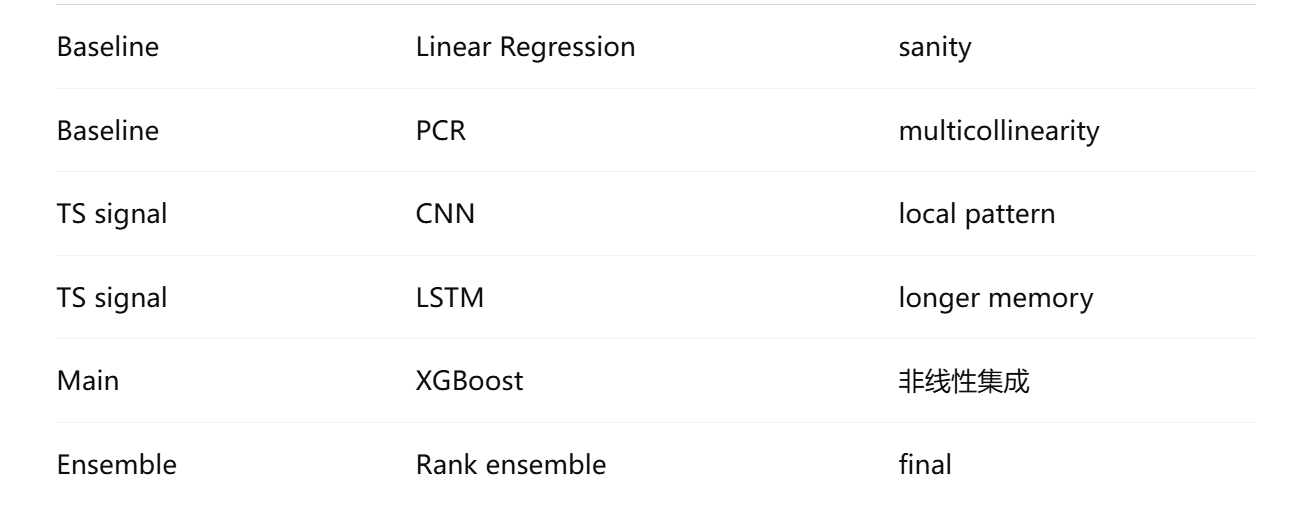

1️⃣ Linear Regression baseline

In [ ]:
from sklearn.linear_model import LinearRegression
base_features = ['mom_20', 'vol_20', 'Open','Close','High','Low']
lr = LinearRegression()
lr_pred, y_true = walk_forward_predictions(
    df, base_features, lr
)
print(lr_pred.head())
print(y_true.head())


1355    0.000372
1356    0.000414
1357    0.003524
1358   -0.007301
1359    0.011085
dtype: float64
1355    0.016520
1356    0.042630
1357    0.035740
1358    0.014246
1359    0.033152
Name: return, dtype: float64


In [ ]:
lr_pred.tail()

,0
3750,-0.005409
3751,-0.002835
3752,-0.002697
3753,0.003576
3754,-0.004638


2️⃣ PCR（Principal Component Regression）

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


In [ ]:
pcr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('ridge', Ridge(alpha=1.0))
])


In [ ]:
pcr_pred, _ = walk_forward_predictions(
    df, base_features, pcr
)
pcr_pred.head()

,0
1355,0.002686
1356,0.000170
1357,0.005108
1358,-0.001967
1359,0.000388


3. NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 特征
features = [c for c in df.columns if 'feat' in c]

# 训练/测试划分
X = df[features].values
y = df['return'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 构建简单 NN
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # 回归输出
])

nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


5️⃣ Walk-forward + XGBoost

In [ ]:
import xgboost as xgb
def walk_forward_predictions(df, features, model, train_window=252):
    preds, trues = [], []
    dates = sorted(df['Date'].unique())

    for i in range(train_window, len(dates)):
        train_dates = dates[i-train_window:i]
        test_date = dates[i]

        train = df[df['Date'].isin(train_dates)]
        test = df[df['Date'] == test_date]

        model.fit(train[features], train['return'])
        p = model.predict(test[features])

        preds.append(pd.Series(p, index=test.index))
        trues.append(test['return'])

    return pd.concat(preds), pd.concat(trues)


In [ ]:
xgb_model = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=200,
    learning_rate=0.05
)

features = ['mom_20', 'vol_20', 'cnn_signal']

xgb_pred, y_true = walk_forward_predictions(df_, features, xgb_model)


In [ ]:
xgb_pred #just a demo

,0
2819,0.002702
2824,-0.007506
2829,-0.002024
2834,-0.007327
2839,0.002469
...,...
3734,0.000231
3739,-0.023381
3744,-0.006888
3749,-0.012987


In [ ]:
signals = pd.DataFrame({
    'xgb': xgb_pred,
    'cnn': df_.loc[xgb_pred.index, 'cnn_signal']
})

final_score = signals.rank(axis=0).mean(axis=1)
final_score


,0
2819,151.5
2824,93.5
2829,126.5
2834,93.0
2839,117.0
...,...
3734,132.0
3739,43.5
3744,107.0
3749,57.0


## Time-series signals（CNN & LSTM，challenge-safe 版）
⚠️ 核心原则

一次训练，多次使用

1️⃣ CNN signal（pooled，快 & defendable）

In [ ]:
def build_cnn():
    model = Sequential([
        Conv1D(8, 3, activation='relu', input_shape=(20,1)),
        GlobalAveragePooling1D(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


### 构造 pooled 训练集(全股票样本一起) 不分开训练个体CNN

In [ ]:
X, y = [], []

for asset, g in df.groupby('Ticker'):
    r = g['return'].values
    for i in range(20, int(len(r)*0.8)):
        X.append(r[i-20:i])
        y.append(r[i])

X = np.array(X)[..., np.newaxis]
y = np.array(y)


In [ ]:
cnn = build_cnn()
cnn.fit(X, y, epochs=5, batch_size=128, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### CNN signal（forward only）

In [ ]:
def cnn_signal(df, model, lookback=20):
    s = []
    for asset, g in df.groupby('Ticker'):
        r = g['return'].values
        sig = [np.nan]*lookback
        for i in range(lookback, len(r)):
            sig.append(
                model.predict(r[i-lookback:i].reshape(1,lookback,1))[0,0]
            )
        s.extend(sig)
    return s


In [ ]:
def cnn_signal_oos(df, model, lookback=20, train_ratio=0.8):
    s = []
    for asset, g in df.groupby('Ticker'):
        r = g['return'].values
        train_end = int(len(r)*train_ratio)

        # 训练
        X_train, y_train = [], []
        for i in range(lookback, train_end):
            X_train.append(r[i-lookback:i])
            y_train.append(r[i])
        X_train = np.array(X_train)[..., np.newaxis]
        y_train = np.array(y_train)
        model.fit(X_train, y_train, epochs=5, verbose=0)

        # 生成信号
        sig = [np.nan]*train_end  # 前面都是 NaN
        for i in range(train_end, len(r)):
            x = r[i-lookback:i].reshape(1, lookback, 1)
            sig.append(model.predict(x)[0,0])
        s.extend(sig)
    return s


2️⃣ LSTM signal（同样套路，极简）

In [ ]:
from tensorflow.keras.layers import LSTM
def build_lstm():
    model = Sequential([
        LSTM(8, input_shape=(20,1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
lstm = build_lstm()
lstm.fit(X, y, epochs=5, batch_size=128, verbose=0)

df['lstm_signal'] = cnn_signal(df, lstm)


六、Main model：XGBoost（加 TS signals）

In [ ]:
features_all = base_features + ['cnn_signal', 'lstm_signal'] #如果是滚动可以 如果OOS就只能ensemble比较
xgb_pred, _ = walk_forward_predictions(
    df, features_all,
    xgb.XGBRegressor(max_depth=3, n_estimators=200, learning_rate=0.05)
)


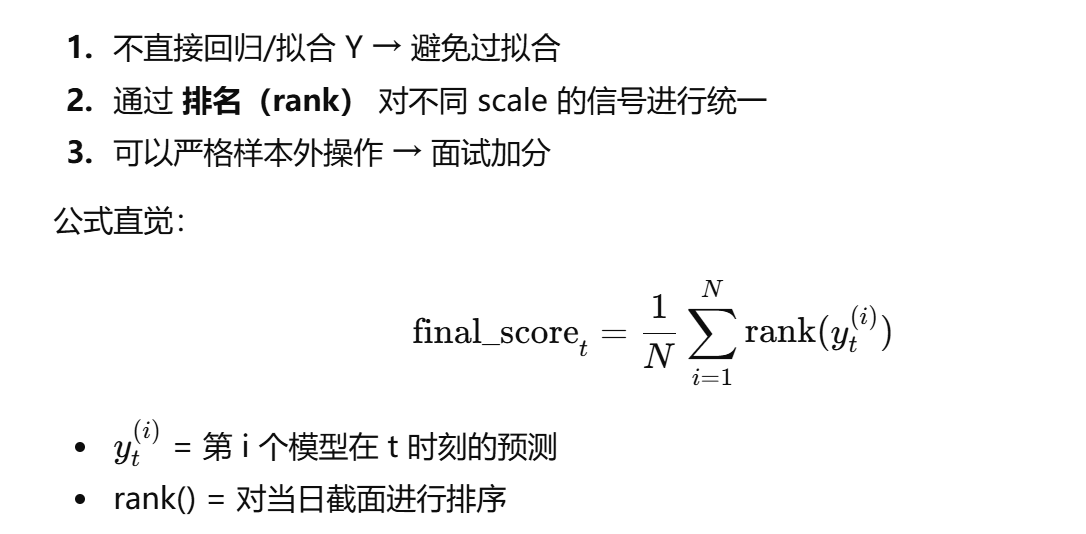

https://www.geeksforgeeks.org/machine-learning/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/

Baselines :Linear PCR NN XGBoost ARIMA/LSTM/1D-CNN signals

假设我们有以下模型预测：

baseline LR → y_hat_lr

baseline PCR → y_hat_pcr

XGBoost → y_hat_xgb

CNN/LSTM 信号 → cnn_signal、lstm_signal

1️⃣ 收集 OOS 预测结果

In [ ]:
import pandas as pd

signals = pd.DataFrame({
    'lr': y_hat_lr,
    'pcr': y_hat_pcr,
    'xgb': y_hat_xgb,
    'cnn': cnn_signal,   # 如果是严格样本外
    'lstm': lstm_signal  # 如果是严格样本外
})



2️⃣ 当日截面排名

In [ ]:
# 对每个交易日（date）做截面排名
ranked = signals.groupby(df['date']).rank(axis=1)

#axis=1 表示对同一天所有股票进行排名

#默认从小到大

3️⃣ 融合排名（简单平均）

In [ ]:
final_score = ranked.mean(axis=1)


结果：每只股票每天有一个 ensemble 信号

核心原则：严格 OOS → 所有列信号均来自当日之前训练好的模型

三、对比 baseline 的方法


1️⃣ 计算 IC（信息系数）

IC = 当日预测和真实收益的皮尔逊相关系数（截面）

In [ ]:
import numpy as np

def mean_ic(pred, y, df):
    ics = []
    for d in df['date'].unique():
        idx = df[df['date']==d].index
        if len(idx) > 2:
            ics.append(np.corrcoef(pred.loc[idx], y.loc[idx])[0,1])
    return np.mean(ics)


输入：

pred = rank ensemble 信号 OR baseline 信号

y = 实际收益

2️⃣ 可视化 IC 对比

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['date'].unique(),
         df.groupby('date').apply(lambda x: np.corrcoef(final_score.loc[x.index], df.loc[x.index,'return'])[0,1]),
         label='Rank Ensemble')
plt.plot(df['date'].unique(),
         df.groupby('date').apply(lambda x: np.corrcoef(y_hat_lr.loc[x.index], df.loc[x.index,'return'])[0,1]),
         label='LR baseline')
plt.xlabel('Date')
plt.ylabel('IC')
plt.title('Daily IC Comparison')
plt.legend()
plt.show()


3️⃣ 统计显著性对比（可选）

用 DM test 或 bootstrap 对 IC 序列做差分检验

如果 rank ensemble IC 均值显著高于 baseline → 说明模型融合有价值

标准 DM test：可直接跑的代码


(1) 构造 loss 序列

In [ ]:
loss_base = (y_true - y_pred_base) ** 2
loss_ens  = (y_true - y_pred_ens) ** 2

d = loss_base - loss_ens
d = d.dropna()


(2) Newey–West 方差

In [ ]:
import numpy as np

def newey_west_var(d, lag):
    T = len(d)
    d = d - d.mean()

    gamma0 = np.sum(d * d) / T
    var = gamma0

    for l in range(1, lag + 1):
        weight = 1 - l / (lag + 1)
        gamma = np.sum(d[l:] * d[:-l]) / T
        var += 2 * weight * gamma

    return var


(3) DM statistic + p-value

In [ ]:
from scipy.stats import norm

def dm_test_loss(loss_A, loss_B, lag=5):
    d = (loss_A - loss_B).dropna()
    T = len(d)

    var_d = newey_west_var(d, lag)
    dm_stat = d.mean() / np.sqrt(var_d / T)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

    return dm_stat, p_value


In [ ]:
dm_stat, p_value = dm_test_loss(loss_base, loss_ens, lag=5)
dm_stat, p_value


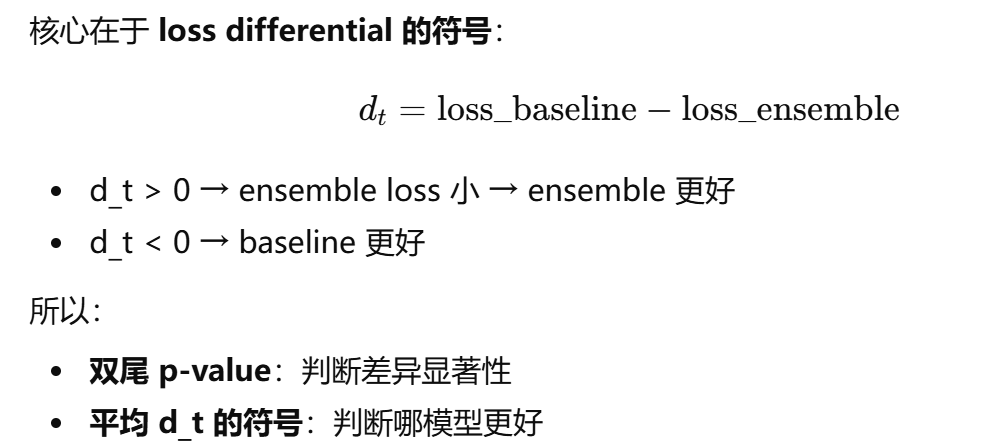

https://github.com/kausik-24/Real-estate-price-prediction 统计量 房价预测参考